In [1]:
import sys
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
def MyFConv2D(input, weight, bias=None, stride=1, padding=0):
    
    """
    My custom Convolution 2D calculation.

    [input]
    * input    : (batch_size, in_channels, input_height, input_width)
    * weight   : (you have to derive the shape :-)
    * bias     : bias term
    * stride   : stride size
    * padding  : padding size

    [output]
    * output   : (batch_size, out_channels, output_height, output_width)
    """

    assert len(input.shape) == len(weight.shape) , "weight shape incorrect"
    assert len(input.shape) == 4, "input shape incorrect"
        
    # batch_size, in_channels, input_height, input_width = input.shape
    N, C_in, H_in, W_in = input.shape
    # weight shape  (C_out, C_in, kH, kW)
    C_out, C_in, kH, kW = weight.shape 
    bias, s, p = bias, stride, padding

    x_pad =  F.pad(input,(p,p,p,p),mode='constant',value=0) # add 2p to last two dims of input
    assert x_pad.shape == (N, C_in, H_in + 2*p, W_in + 2*p) , "padding incorrect"

    H_out = int( (H_in + 2*p - kH) / s) + 1 # output sizes 
    W_out = int( (W_in + 2*p - kW) / s) + 1
    
    output = torch.zeros(N, C_out, H_out, W_out) # initalise output tensor
    
    ## Convolution
    for h in range(H_out):
        for w in range(W_out):
            
            window = x_pad[:, :, h*s:h*s+kH, w*s:w*s+kW]
            # (b,c_in, kH, KW) * (c_o, c_i, kH, kW) -> (b, c_o, _)
            # sum over c_in, kH, kW
            output[:,:, h, w] = torch.tensordot(window, weight, dims=([1,2,3],[1,2,3]))
            if bias is not None:
                output[:,:, h, w] += bias[:]
    return output


In [3]:


class MyConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, bias=True):

        """
        My custom Convolution 2D layer.

        [input]
        * in_channels  : input channel number
        * out_channels : output channel number
        * kernel_size  : kernel size
        * stride       : stride size
        * padding      : padding size
        * bias         : taking into account the bias term or not (bool)

        """
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.bias = bias

        ## Create the torch.nn.Parameter for the weights and bias (if bias=True)
        ## Be careful about the size
        # weight shape  (C_out, C_in, kH, kW)
        # N, C_in, H_in, W_in = input.shape

        self.W =  nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size))
        self.b = nn.Parameter(torch.zeros(out_channels)) if bias else None

        # out = ( (2*p + H - k) / s ) + 1            
    
    def __call__(self, x):
        
        return self.forward(x)


    def forward(self, x):
        
        """
        [input]
        x (torch.tensor)      : (batch_size, in_channels, input_height, input_width)

        [output]
        output (torch.tensor) : (batch_size, out_channels, output_height, output_width)
        """

        # call MyFConv2D here
        output = MyFConv2D(x, self.W, self.b, self.stride, self.padding)
        return output

In [4]:

# Create inputs for validation
batch_size, in_channels, H, W = 4,5,8,10 # Example dimensions
out_channels = 3
kernel_size = 3
stride = 1
padding = 2

# Input and weights
input_tensor = torch.rand(batch_size, in_channels, H, W)
weights = torch.rand(out_channels, in_channels, kernel_size, kernel_size)
bias = torch.zeros(out_channels)

# custom_conv_output = MyFConv2D(input_tensor, weights, bias, stride, padding)

myConvd2D = MyConv2D(in_channels, out_channels, kernel_size, stride, padding)


conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
conv2d.weight.data = myConvd2D.W.data.clone()
conv2d.bias.data = myConvd2D.b.data.clone()

# Apply PyTorch Conv2D
with torch.no_grad():  # Ensure Conv2D weight and bias are not updated
    torch_conv_output = conv2d(input_tensor)


my_conv_output = myConvd2D(input_tensor)

# Compare outputs
print("Output Difference:", torch.sum(torch_conv_output - my_conv_output))


Output Difference: tensor(0., grad_fn=<SumBackward0>)


In [5]:
input_tensor.shape

torch.Size([4, 5, 8, 10])

In [6]:
a = b = 0
a = 1

In [7]:
# Epoch 1  | Train Loss: 1.5684 | Train Acc: 0.5666 | Val Loss: 0.9956 | Val Acc: 0.7626
# Epoch 2  | Train Loss: 0.6898 | Train Acc: 0.8379 | Val Loss: 0.6110 | Val Acc: 0.8464
# Epoch 3  | Train Loss: 0.4591 | Train Acc: 0.8844 | Val Loss: 0.4750 | Val Acc: 0.8694
# Epoch 4  | Train Loss: 0.3624 | Train Acc: 0.9031 | Val Loss: 0.3965 | Val Acc: 0.8864
# Epoch 5  | Train Loss: 0.3070 | Train Acc: 0.9145 | Val Loss: 0.3534 | Val Acc: 0.8954
# Epoch 6  | Train Loss: 0.2706 | Train Acc: 0.9235 | Val Loss: 0.3187 | Val Acc: 0.9032
# Epoch 7  | Train Loss: 0.2445 | Train Acc: 0.9286 | Val Loss: 0.2925 | Val Acc: 0.9080
# make a list of losses and accuracies
train_loss = [1.5684, 0.6898, 0.4591, 0.3624, 0.3070, 0.2706, 0.2445]
train_accuracy = [0.5666, 0.8379, 0.8844, 0.9031, 0.9145, 0.9235, 0.9286]
val_loss = [0.9956, 0.6110, 0.4750, 0.3965, 0.3534, 0.3187, 0.2925]
val_accuracy = [0.7626, 0.8464, 0.8694, 0.8864, 0.8954, 0.9032, 0.9080]

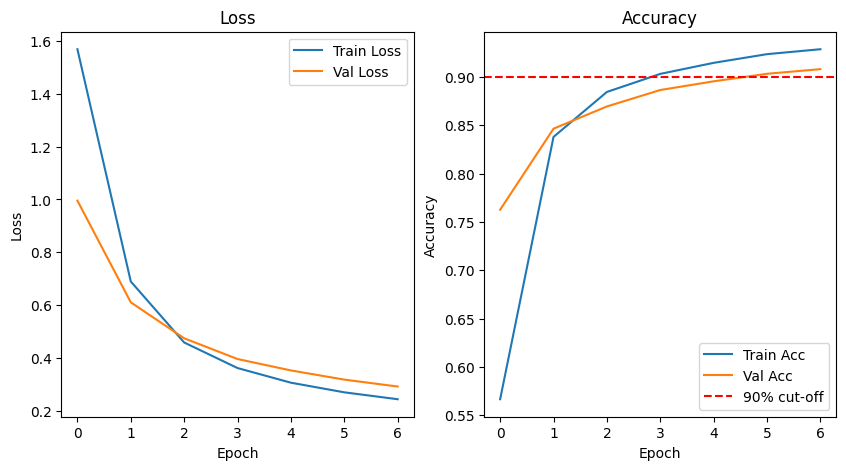

In [8]:
import matplotlib.pyplot as plt

## Plot the loss and accuracy curves
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(train_loss, label='Train Loss')
ax[0].plot(val_loss, label='Val Loss')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(train_accuracy, label='Train Acc')
ax[1].plot(val_accuracy, label='Val Acc')
ax[1].set_title('Accuracy')
ax[1].legend()
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].axhline(y=0.9, color='r', linestyle='--', label='90% cut-off')
ax[1].legend()
plt.savefig('train-loss-curve-del1-2.png')
plt.show()


In [49]:

train_loss = [
    0.7180, 0.6359, 0.5782, 0.5362, 0.4877, 0.4600, 0.4254, 0.3964, 0.3739, 
    0.3478, 0.3267, 0.3057, 0.2899, 0.2696, 0.2557, 0.2463, 0.2274, 0.2145, 
    0.2020, 0.1964, 0.1839, 0.1719, 0.1675, 0.1610, 0.1573, 0.1460, 0.1357, 
    0.1393, 0.1306, 0.1227
]

train_accuracy = [
    0.7489, 0.7775, 0.7987, 0.8135, 0.8329, 0.8404, 0.8529, 0.8613, 0.8709, 
    0.8787, 0.8861, 0.8925, 0.8992, 0.9074, 0.9098, 0.9142, 0.9211, 0.9260, 
    0.9310, 0.9321, 0.9349, 0.9401, 0.9420, 0.9438, 0.9467, 0.9491, 0.9523, 
    0.9514, 0.9539, 0.9587
]

val_loss = [
    0.7228, 0.6963, 0.7095, 0.6472, 0.5775, 0.6222, 0.6284, 0.5418, 0.5197, 
    0.5211, 0.5461, 0.4949, 0.5026, 0.5288, 0.5075, 0.4827, 0.5006, 0.4943, 
    0.5065, 0.4826, 0.5496, 0.5164, 0.4948, 0.4831, 0.5056, 0.4836, 0.5152, 
    0.5040, 0.5459, 0.4996
]

val_accuracy = [
    0.7457, 0.7637, 0.7642, 0.7796, 0.7978, 0.7878, 0.7884, 0.8159, 0.8262, 
    0.8255, 0.8205, 0.8365, 0.8328, 0.8284, 0.8380, 0.8394, 0.8459, 0.8491, 
    0.8428, 0.8500, 0.8346, 0.8484, 0.8536, 0.8538, 0.8547, 0.8596, 0.8461, 
    0.8528, 0.8490, 0.8570
]


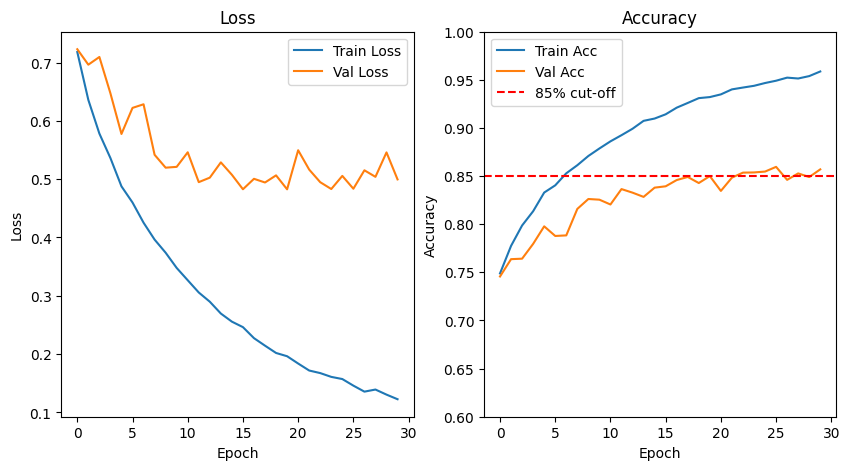

In [56]:
import matplotlib.pyplot as plt

## Plot the loss and accuracy curves
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(train_loss, label='Train Loss')
ax[0].plot(val_loss, label='Val Loss')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
# ax[0].set_ylim(0.5, 1)
ax[0].legend()

ax[1].plot(train_accuracy, label='Train Acc')
ax[1].plot(val_accuracy, label='Val Acc')
ax[1].set_title('Accuracy')
ax[1].set_ylim(0.6, 1)

ax[1].legend()
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].axhline(y=0.85, color='r', linestyle='--', label='85% cut-off')
ax[1].legend()

plt.savefig('train-loss-curve-del3-4-final.png', dpi = 400)
plt.show()


In [15]:
# o = ( (2p + N-k)/s) + 1
def padding(input, output, k, s):
    return int( ((output-1) *s -input+k) /2)
def output(input, p, k, s):
    return int( (input + 2*p - k) / s) + 1

padding(32, 32, 3, 2)

(16, 1)

In [43]:
print('residual', padding(32, 16, 1, 2) )


print('output 1 ', output(32,1, 3, 2) )

input_2 = output(32, 1, 3, 2)

print('padding', padding(input_2, 16, 3, 1)  )
# print('output 2 ', output(input_2, 3, 3, 2) )

residual 0
output 1  16
padding 1


In [45]:
# print('residual', padding(16, 8, 1, 2) )
# print('output 1 ', output(16, 3, 3, 2) )
# input_2 = output(16, 3, 3, 2)
# print('padding', padding(input_2, 8, 3, 1)  )

In [46]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super().__init__()
        """
        My custom ResidualBlock

        [input]
        * in_channels  : input channel number
        * out_channels : output channel number
        * kernel_size  : kernel size
        * stride       : stride size

        [hint]
        * See the instruction PDF for details
        * Set the bias argument to False
        """
        
        ## Define all the layers
        self.conv_1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv_2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.residual = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, padding=0, bias=False)
        self.relu = nn.ReLU()

    def forward(self, x):
    #    output = int( (input + 2*p - k) / s) + 1
    #    padding = int( ((output-1) *s -input+k) /2)
        residual = self.residual(x)
        x = self.conv_1(x)
        x = self.conv_2(x)
        x += residual
        x = self.relu(x)
        return x

In [47]:
conv = nn.Conv2d(3,64, kernel_size = 3,stride=1, padding = 1)
x = torch.rand(1,3,32,32)
x = conv(x)
x.size()

torch.Size([1, 64, 32, 32])

In [48]:
residual_block1 = ResidualBlock(64, 2*64, 3, 2)
residual_block1.forward(x).shape

torch.Size([1, 128, 16, 16])